<h1> Custom Named Entity Recognizer</h1>

Named entity recognizer's are generally trained on texts from web articles or news articles. In such cases they are not able to recognize entities from finance or medical domain. For such use cases, we need to train the NER using domain specific labelled data. 

If training data is large then we may train an NER from scratch. But if we don't have sufficient data then we may retrain a previously trained NER with new data.

For this use case since our data is large enough to train an NER model from scratch.
<br>

<h3>Problem Description</h3>

The core problem that we are trying to solve here is :- Given a text (sentence), we have to find out the different types of entities in that text, e.g - names of people, organizations, places etc. 

We can model it as a **many-to-many** sequence prediction problem, i.e, input is a sentence (set of tokens) & output is a set of tags describing each token.
<br>

<h3>Dataset Description :-</h3>

The dataset used was extracted from GMB corpus (Groningen Meaning Bank) & can be found here :- https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus . We have nearly 48K labelled sentences.
<br>

<h3>Plan of Attack</h3>

We are going to train a **Bi-LSTM model** from scratch. We are going to use the Keras library for this task, although we could also use SpaCy for performing this task also - by using an empty pipeline & including an untrained NER in that pipeline.

In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv("ner_dataset.csv", encoding='latin')#ner_dataset.csv
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [4]:
## cHECKING NO.OF ROWS IN THE DATASET
df.shape

(1048575, 4)

In [ ]:
## CHECKING THE POS TAGS IN THIS DATASET
df["POS"].unique()

array(['NNS', 'IN', 'VBP', 'VBN', 'NNP', 'TO', 'VB', 'DT', 'NN', 'CC',
       'JJ', '.', 'VBD', 'WP', '``', 'CD', 'PRP', 'VBZ', 'POS', 'VBG',
       'RB', ',', 'WRB', 'PRP$', 'MD', 'WDT', 'JJR', ':', 'JJS', 'WP$',
       'RP', 'PDT', 'NNPS', 'EX', 'RBS', 'LRB', 'RRB', '$', 'RBR', ';',
       'UH', 'FW'], dtype=object)

In [ ]:
## CHECKING THE UNIQUE TAGS IN THIS DATASET
print("No.of unique tags :- ",len(df["Tag"].unique()))
print("Unique tags are :-\n",df["Tag"].unique())

No.of unique tags :-  17
Unique tags are :-
 ['O' 'B-geo' 'B-gpe' 'B-per' 'I-geo' 'B-org' 'I-org' 'B-tim' 'B-art'
 'I-art' 'I-per' 'I-gpe' 'I-tim' 'B-nat' 'B-eve' 'I-eve' 'I-nat']


**Therefore no.of output classes is 17**

In [4]:
## INDEXING EACH UNIQUE TOKEN
vocab = list(set(data["Word"].values))
idx2word = {idx:tok for  idx, tok in enumerate(vocab)}
word2idx = {tok:idx for  idx, tok in enumerate(vocab)}

## INDEXING EACH UNIQUE TAG
tags = list(set(data["Tag"].values))
idx2tag = {idx:tok for  idx, tok in enumerate(tags)}
tag2idx = {tok:idx for  idx, tok in enumerate(tags)}

In [5]:
## CHECKING NO.OF UNIQUE TOKENS & TAGS
n_token, n_tags = len(vocab), len(tags)
print(n_token, n_tags)

35178 17


In [6]:
data['Word_idx'] = data['Word'].map(word2idx)
data['Tag_idx'] = data['Tag'].map(tag2idx)
data.head()

,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,Thousands,NNS,O,19018,10
1,NaN,of,IN,O,28958,10
2,NaN,demonstrators,NNS,O,6523,10
3,NaN,have,VBP,O,26274,10
4,NaN,marched,VBN,O,22699,10


In [7]:
## Fill na
data_fillna = data.fillna(method='ffill', axis=0)

## Grouping the tokens to sentences
data_group = data_fillna.groupby(['Sentence #'],
                                 as_index=False)['Word', 'POS', 'Tag', 
                                                 'Word_idx', 'Tag_idx'].agg(lambda x: list(x))
## Visualise data
data_group.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...","[19018, 28958, 6523, 26274, 22699, 24439, 2842...","[10, 10, 10, 10, 10, 10, 14, 10, 10, 10, 10, 1..."
1,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[13322, 22989, 12146, 19667, 9546, 28280, 3462...","[4, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10..."
2,Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, ...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...","[9218, 16783, 1307, 20430, 7430, 15039, 31013,...","[10, 10, 7, 10, 10, 10, 10, 10, 14, 10, 10, 10..."
3,Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[O, O, O, O, O, O, O, O, O, O, O]","[25096, 1196, 19790, 18480, 26691, 17302, 304,...","[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]"
4,Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, J...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo...","[17382, 21132, 5856, 3268, 1865, 17041, 9654, ...","[14, 10, 10, 3, 8, 10, 7, 10, 14, 10, 4, 10, 4..."


In [8]:
data_group.shape

(47959, 6)

**So we have a total of 47959 labelled sentences.**

<h2>Model Training</h2>

In [9]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

In [11]:
import numpy as np
import tensorflow
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Activation  
from tensorflow.keras.utils import plot_model

## Seed for reproducibility
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)

In [12]:
## Finding dimensions of embedding layer
input_dim = len(list(set(data['Word'].to_list())))+1
output_dim = 64
input_length = max([len(s) for s in data_group['Word_idx'].tolist()])
print('input_dim: ', input_dim, '\noutput_dim: ', output_dim, '\ninput_length: ', input_length, '\nn_tags: ', n_tags)

input_dim:  35179 
output_dim:  64 
input_length:  104 
n_tags:  17


In [13]:
def get_bilstm_lstm_model():
    model = Sequential()

    # Add Embedding layer
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))

    # Add bidirectional LSTM
    model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat'))

    # Add LSTM
    model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))

    # Add timeDistributed Layer
    model.add(TimeDistributed(Dense(n_tags, activation="relu"))) 

    #Optimiser 
    # adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [ ]:
model_bilstm_lstm = get_bilstm_lstm_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 104, 64)           2251456   
_________________________________________________________________
bidirectional (Bidirectional (None, 104, 128)          66048     
_________________________________________________________________
lstm_1 (LSTM)                (None, 104, 64)           49408     
_________________________________________________________________
time_distributed (TimeDistri (None, 104, 17)           1105      
Total params: 2,368,017
Trainable params: 2,368,017
Non-trainable params: 0
_________________________________________________________________


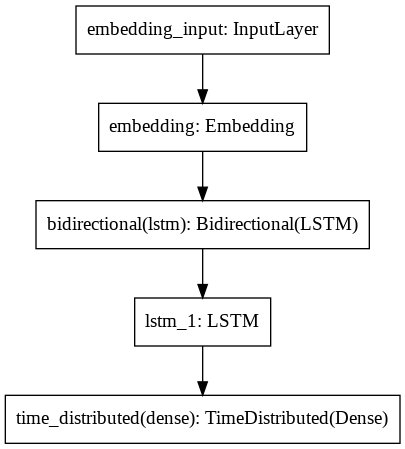

In [ ]:
## Visualizing the model
plot_model(model_bilstm_lstm)

In [14]:
## UTILITY FUNCTIONS

def find_tags(arr3d):

  idxs = []
  for sent in arr3d:
    for token in sent:
      idxs.append(np.argmax(token))
  return idxs

def test_accuracy(pred_tags, orig_tags):
  total, corr = len(pred_tags), 0
  
  for pred_tag, orig_tag in zip(pred_tags, orig_tags):
    if pred_tag == orig_tag:
      corr += 1
  
  return corr/total

## K-fold cross validation

I am going to use a 10 fold cross-validation for training the model.

In [15]:
## Randomly shuffling the datapoints
data_group = data_group.sample(frac=1)

## Splitting up data into train & test set
train_data_group = data_group[:45000]
test_data_group = data_group[45000:]
print("Train data shape :- ",train_data_group.shape)
print("Test data shape :- ",test_data_group.shape)

kfold = 10
fold_idxs = [(i % kfold) for i in range(train_data_group.shape[0])]

train_data_group["Fold_id"] = fold_idxs
train_data_group.head(3)

Train data shape :-  (45000, 6)
Test data shape :-  (2959, 6)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,Sentence #,Word,POS,Tag,Word_idx,Tag_idx,Fold_id
31157,Sentence: 3804,"[AN, OWL, ,, in, her, wisdom, ,, counseled, th...","[DT, NN, ,, IN, PRP$, NN, ,, VBD, DT, NNS, WDT...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[12859, 16427, 31857, 31013, 28818, 8291, 3185...","[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1...",0
3883,Sentence: 13493,"[The, prisoners, ', identities, were, not, imm...","[DT, NNS, POS, NNS, VBD, RB, RB, VBN, ,, CC, N...","[O, O, O, O, O, O, O, O, O, O, B-gpe, O, O, O,...","[9958, 6680, 10147, 12726, 25535, 18249, 18099...","[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 4, 10...",1
31140,Sentence: 38024,"[The, bill, won, final, approval, in, the, Sta...","[DT, NN, VBD, JJ, NN, IN, DT, NN, NNP, IN, DT,...","[O, O, O, O, O, O, O, B-geo, I-geo, O, O, O, O...","[9958, 2128, 32260, 10709, 32257, 31013, 23093...","[10, 10, 10, 10, 10, 10, 10, 14, 11, 10, 10, 1...",2


In [16]:
maxlen = max([len(s) for s in train_data_group['Word_idx'].tolist()])
maxlen

104

In [19]:
import time

In [25]:
def get_pad_tokens_tags(tokens, tags, maxlen, n_token, n_tags):
  """Returns padded tokens & tags"""

  ## Padding tokens
  pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value=n_token-1)
  
  ## Padding tags & one hot encoding them
  pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value=tag2idx["O"])
  pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags] 

  return (pad_tokens, pad_tags)

def crossval(train_data_group, test_data_group, maxlen, n_token, n_tags, kfold):
    """Returns the history & test-set accuracy for all folds."""
    
    hist_ls, test_acc_ls = [], []
    batch_size = 1024
    num_epochs = 5
  
    test_tokens = test_data_group['Word_idx'].tolist()
    test_tags = test_data_group['Tag_idx'].tolist()    
    
    ## Get padded tokens & tags for testing model on unseen data
    test_pad_tokens, test_pad_tags = get_pad_tokens_tags(test_tokens, test_tags, maxlen, n_token, n_tags)   

    for i in range(kfold):

      train_data_grp = train_data_group[train_data_group["Fold_id"] != i]
      val_data_grp = train_data_group[train_data_group["Fold_id"] == i]

      ## Tokens - (X var) , Tags - (Y var)   
      train_tokens = train_data_grp['Word_idx'].tolist()
      train_tags = train_data_grp['Tag_idx'].tolist()
      val_tokens = val_data_grp['Word_idx'].tolist()
      val_tags = val_data_grp['Tag_idx'].tolist()

      ## Get padded tokens & tags
      train_pad_tokens, train_pad_tags = get_pad_tokens_tags(train_tokens, train_tags, maxlen, n_token, n_tags)      
      val_pad_tokens, val_pad_tags = get_pad_tokens_tags(val_tokens, val_tags, maxlen, n_token, n_tags)

      ## Getting new model
      model = get_bilstm_lstm_model()

      # Saving the best model only
      filepath="ner-bi-lstm-fold{}.hdf5".format(i)
      checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
      callbacks_list = [checkpoint]

      print("Training started with validation fold-{}".format(i))
      st = time.time()
      hist = model.fit(train_pad_tokens, 
                       np.array(train_pad_tags), 
                       batch_size=batch_size, 
                       verbose=0, 
                       epochs=num_epochs, 
                       validation_data = (val_pad_tokens, np.array(val_pad_tags)), 
                       callbacks=callbacks_list) 
      en = time.time()
      print("Fold-{} training time = {} mins".format(i,(en-st)/60)) 
      hist_ls.append(hist)    

      pred = model.predict(test_pad_tokens)
      pred_tags = find_tags(pred)
      orig_tags = find_tags(np.array(test_pad_tags))
      
      test_acc = test_accuracy(pred_tags, orig_tags)
      test_acc_ls.append(test_acc)
      print("Fold {} complete. Test set accuracy - {}".format(i, test_acc))
      print("*"*100+"\n\n")

    
    return (hist_ls, test_acc_ls)

In [26]:
hist_ls, test_acc_ls = crossval(train_data_group, test_data_group, maxlen, n_token, n_tags, kfold)

Training started with validation fold-0

Epoch 00001: val_accuracy improved from -inf to 0.96799, saving model to ner-bi-lstm-fold0.hdf5

Epoch 00002: val_accuracy did not improve from 0.96799

Epoch 00003: val_accuracy did not improve from 0.96799

Epoch 00004: val_accuracy did not improve from 0.96799

Epoch 00005: val_accuracy did not improve from 0.96799
Fold-0 training time = 7.179142208894094 mins
Fold 0 complete. Test set accuracy - 0.9680992799022539
****************************************************************************************************


Training started with validation fold-1

Epoch 00001: val_accuracy improved from -inf to 0.96757, saving model to ner-bi-lstm-fold1.hdf5

Epoch 00002: val_accuracy did not improve from 0.96757

Epoch 00003: val_accuracy did not improve from 0.96757

Epoch 00004: val_accuracy improved from 0.96757 to 0.96758, saving model to ner-bi-lstm-fold1.hdf5

Epoch 00005: val_accuracy improved from 0.96758 to 0.96768, saving model to ner-bi-l

In [27]:
## TEST SET ACCURACIES
test_acc_ls

[0.9680992799022539,
 0.9681967660592196,
 0.9680927808251228,
 0.9680927808251228,
 0.9680960303636884,
 0.9680927808251228,
 0.9681317752879092,
 0.9680927808251228,
 0.9680927808251228,
 0.9680960303636884]

**BEST TEST SET ACCURACY ACHIEVED IS 96.82%**